In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel("/content/drive/MyDrive/ExcelData/train.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install niapy

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization


class LRFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.7
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(LogisticRegression(solver='liblinear',multi_class='ovr', max_iter=1000), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import time


hyperspectral_data = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
feature_names = df.columns[:-1].values

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X = hyperspectral_data
y = encoded_labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)
problem = LRFeatureSelection(X_train, y_train)
task = Task(problem, max_iters=100)
algorithm = ParticleSwarmOptimization(population_size=10, seed=1234)
best_features, best_fitness = algorithm.run(task)

In [5]:
selected_features = best_features > 0.7
print('Number of selected features:', selected_features.sum())
print('Selected features:\n', feature_names[selected_features])
# print(len(feature_names[selected_features]))

start = time.perf_counter()

model_selected = LogisticRegression(solver='liblinear',multi_class='ovr', max_iter=1000)


model_selected.fit(X_train[:, selected_features], y_train)

end = time.perf_counter()

y_pred = model_selected.predict(X_test[:, selected_features])

Number of selected features: 79
Selected features:
 [908.06 917.74 927.42 932.26 937.11 941.96 946.81 961.36 966.21 1005.09
 1019.69 1024.56 1029.43 1034.31 1039.18 1048.93 1058.69 1068.45 1073.34
 1078.22 1088 1097.77 1117.35 1122.25 1132.04 1136.94 1141.85 1151.66
 1156.56 1171.29 1176.2 1181.11 1205.7 1210.62 1225.39 1235.25 1245.11
 1250.04 1254.97 1259.91 1279.66 1358.89 1363.85 1368.82 1378.75 1383.72
 1388.69 1398.63 1403.61 1408.58 1428.5 1443.45 1463.4 1468.39 1473.38
 1498.37 1503.37 1513.38 1518.38 1523.39 1528.4 1533.4 1553.45 1573.53
 1578.55 1588.59 1598.65 1603.67 1623.8 1628.83 1643.95 1648.99 1659.07
 1664.12 1669.16 1674.21 1679.26 1694.41 1714.63]


In [6]:
print('Subset accuracy:', model_selected.score(X_test[:, selected_features], y_test))
print('Time taken:', end-start, 'sec')

Subset accuracy: 0.8705035971223022
Time taken: 0.06097443100009059 sec


Confusion Matrix:


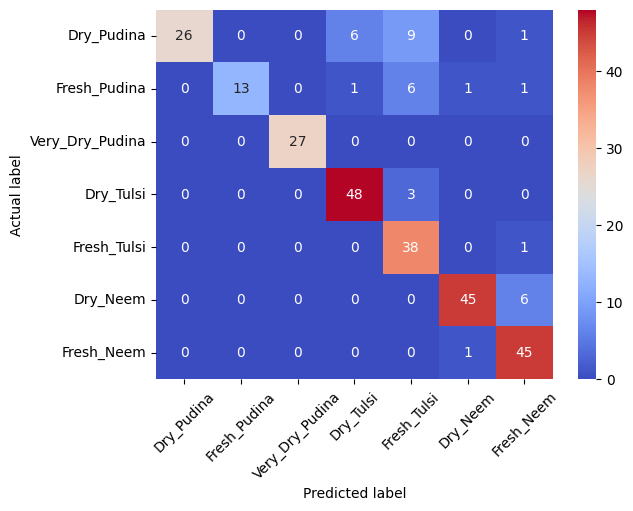

In [7]:
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)
lb = ['Dry_Pudina', 'Fresh_Pudina', 'Very_Dry_Pudina', 'Dry_Tulsi', 'Fresh_Tulsi', 'Dry_Neem', 'Fresh_Neem']
confusion_mat = confusion_matrix(y_test,y_pred, labels=lb)
print("Confusion Matrix:")
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=lb,
    yticklabels=lb,
)
plt.xticks(rotation=45)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()